In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from analysis_helpers import poisson_waiting_function, \
                            run_multiple_trajectories, \
                            plot_aip_vs_t, \
                            plot_cip_vs_t, \
                            run_sensitivity_sims, \
                            extract_cips, \
                            load_sim_dir

In [2]:
sim_dirs = """daily_contacts_fall_testing.1589998089.7
daily_contacts_base.1589998089.61
mild_self_reporting_base.1589998089.62
mild_self_reporting_fall.1589998089.62
mild_self_reporting_fall_testing.1589998089.64
contact_recall_base.1589998089.66
testing_fraction_fall_testing.1589998089.62
daily_contacts_fall.1589998089.56
exposed_infection_p_fall_testing.1589998089.62
contact_delay_fall.1589998089.62
contact_delay_base.1589998089.62
contact_delay_fall_testing.1589998089.64
contact_recall_fall.1589998089.61
exposed_infection_p_fall.1589998089.61
severe_self_reporting_base.1589998089.63
prevalence_base.1589998089.56
testing_qfnr_fall_testing.1589998089.56
contact_recall_fall_testing.1589998089.56
prevalence_fall.1589998089.56
prevalence_fall_testing.1589998089.56
severe_self_reporting_fall_testing.1589998089.56
exposed_infection_p_base.1589998089.56
severe_self_reporting_fall.1589998089.56""".split('\n')

fall_sim_results = {}
base_sim_results = {}
fall_testing_results = {}

unallocated_results = []

for folder in sim_dirs:
    sims_in_dir = load_sim_dir("/nfs01/covid_sims/" + folder, verbose=False)
    print("Done loading {}".format(folder))
    if '_base' in folder:
        param_name = folder.split('_base')[0]
        base_sim_results[param_name] = sims_in_dir
    elif '_fall_testing' in folder:
        param_name = folder.split('_fall_testing')[0]
        fall_testing_results[param_name] = sims_in_dir
    elif '_fall' in folder:
        param_name = folder.split('_fall')[0]
        fall_sim_results[param_name] = sims_in_dir
    else:
        print("couldn't determinie fall or base")
        unallocated_results.append(sims_in_dir)

Done loading daily_contacts_fall_testing.1589998089.7
Done loading daily_contacts_base.1589998089.61
Done loading mild_self_reporting_base.1589998089.62
Done loading mild_self_reporting_fall.1589998089.62
Done loading mild_self_reporting_fall_testing.1589998089.64
Done loading contact_recall_base.1589998089.66
Done loading testing_fraction_fall_testing.1589998089.62
Done loading daily_contacts_fall.1589998089.56
Done loading exposed_infection_p_fall_testing.1589998089.62
Done loading contact_delay_fall.1589998089.62
Done loading contact_delay_base.1589998089.62
Done loading contact_delay_fall_testing.1589998089.64
Done loading contact_recall_fall.1589998089.61
Done loading exposed_infection_p_fall.1589998089.61
Done loading severe_self_reporting_base.1589998089.63
Done loading prevalence_base.1589998089.56
Done loading testing_qfnr_fall_testing.1589998089.56
Done loading contact_recall_fall_testing.1589998089.56
Done loading prevalence_fall.1589998089.56
Done loading prevalence_fall_te

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
def extract_severities(dfs):
    severities = []
    for df in dfs:
        all_cols = set(df.columns)
        new_cols = set(['cumulative_mild', 
                        'cumulative_severe', 
                        'severity_0', 
                        'severity_1', 
                        'severity_2', 
                        'severity_3'])
        main_cols = all_cols - new_cols
        subdf = df[list(main_cols)]
        popsize = sum(subdf.iloc[0])
        
        subdf = df[['severity_2', 'severity_3']]
        severe = sum(subdf.iloc[subdf.shape[0]-1])
        
        severities.append(100 * severe / popsize)
    return severities
def average_cumulative_severe(dfs):
    severities = []
    for df in dfs:
        all_cols = set(df.columns)
        new_cols = set(['cumulative_mild', 
                        'cumulative_severe', 
                        'severity_0', 
                        'severity_1', 
                        'severity_2', 
                        'severity_3'])
        main_cols = all_cols - new_cols
        subdf = df[list(main_cols)]
        popsize = sum(subdf.iloc[0])
        
        subdf = df[['severity_2', 'severity_3']]
        severe = sum(subdf.iloc[subdf.shape[0]-1])
        
        severities.append(100 * severe / popsize)
    return np.mean(severities)

def avg_cum_severe_quantile(dfs, q_low, q_high):
    severities = extract_severities(dfs)
    return np.quantile(severities, q_low), np.mean(severities), np.quantile(severities, q_high)

def cum_severe_quantiles(dfs, q_low, q_high):
    severities = extract_severities(dfs)
    return np.quantile(severities, q_low), np.quantile(severities, 0.5), np.quantile(severities, q_high)

def plot_many_dfs(sim_output_dict, yaxisfn, ylabel="", xlabel="", title="", figsize=(10,6)):
    plt.figure(figsize=figsize)
    for sim_label, sim_output in sim_output_dict.items():
        xs = []
        ys = []
        for sim_parameter_name, dfs in sim_output.items():
            # compute x-value assuming that sim_param_name is of form 'varied_param_name.value'
            param_val = float('.'.join(sim_parameter_name.split('.')[1:]))
            xs.append(param_val)
            # yaxisfn is a function that takes in a list of trajectory dataframes and
            # produces an output metric
            ys.append(yaxisfn(dfs))
        plt.plot(xs, ys, marker='o', label=sim_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.show()


def truncate(val, y_min, y_max):
    return max(min(val, y_max), y_min)
    
def plot_many_dfs_quantiles(sim_output_dict, yaxisfn, normalize_x_axis, x_log_scale=False, 
                            y_log_scale=False,
                            q_low=0.05, q_high=0.95, 
                            y_min = 0, y_max = 5,
                            ylabel="", xlabel="", title="", figsize=(10,6), alpha=0.1):
    # assn: yaxisfn(dfs) returns a tuple (q_low_val, avg, q_high_val)
    epsilon=1e-6
    plt.figure(figsize=figsize)
    if x_log_scale:
        plt.xscale("log")
    
    for sim_label, sim_output in sim_output_dict.items():
        xs = []
        ys = []
        q_low_vals = []
        q_high_vals = []
        for sim_parameter_name, dfs in sim_output.items():
            # compute x-value assuming that sim_param_name is of form 'varied_param_name.value'
            param_val = float('.'.join(sim_parameter_name.split('.')[1:]))
            if normalize_x_axis:
                xs.append(param_val * 100)
            else:
                xs.append(param_val)
            # yaxisfn is a function that takes in a list of trajectory dataframes and
            # produces an output metric
            q_low_val, avg, q_high_val = yaxisfn(dfs, q_low, q_high)
            if not y_log_scale:
                ys.append(truncate(avg, y_min, y_max))
                q_low_vals.append(truncate(q_low_val, y_min, y_max))
                q_high_vals.append(truncate(q_high_val, y_min, y_max))
            else:
                ys.append(avg + epsilon)
                q_low_vals.append(q_low_val + epsilon)
                q_high_vals.append(q_high_val + epsilon)
        plt.plot(xs, ys, marker='o', label=sim_label)
        plt.fill_between(xs, q_low_vals, q_high_vals, alpha=alpha)
    if y_log_scale:
        plt.yscale("log")
        plt.ylim(bottom=1e-2)
    else:
        plt.ylim(y_min, y_max)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

In [4]:
plot_labels = {
    'daily_contacts': 'Average Contacts per Person per Day',
    'severe_self_reporting': 'Daily Symptomatic Self-Reporting Likelihood',
    'prevalence': 'Initial Prevalence (% of Total Population)',
    'mild_self_reporting': 'Daily Asymptomatic Self-Reporting Likelihood',
    'exposed_infection_p': 'Transmission Likelihood per Contact',
    'contact_recall': 'Percentage of Contacts Recalled in Contact Trace',
    'contact_delay': 'Contact Trace Delay (Days)'
}

normalize_params = {
    'daily_contacts': False,
    'severe_self_reporting': True,
    'prevalence': True,
    'mild_self_reporting': True,
    'exposed_infection_p': True,
    'contact_recall': True,
    'contact_delay': False
}

plot_log_scale = {
    'daily_contacts': False,
    'severe_self_reporting': False,
    'prevalence': True,
    'mild_self_reporting': False,
    'exposed_infection_p': False,
    'contact_recall': False,
    'contact_delay': False    
}

In [40]:
fall_testing_results.keys()

dict_keys(['daily_contacts', 'mild_self_reporting', 'testing_fraction', 'exposed_infection_p', 'contact_delay', 'testing_qfnr', 'contact_recall', 'prevalence', 'severe_self_reporting'])

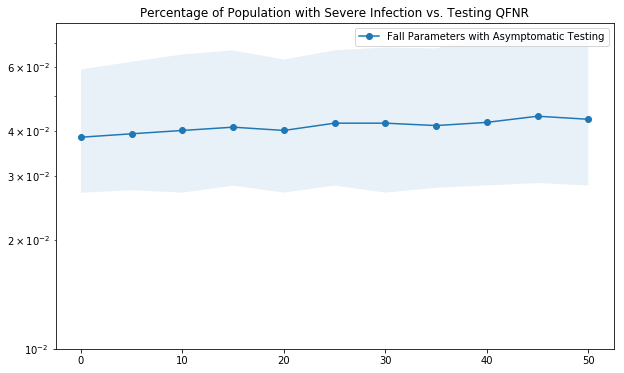

In [43]:
plot_many_dfs_quantiles({'Fall Parameters with Asymptomatic Testing': fall_testing_results['testing_qfnr']}, cum_severe_quantiles,
                       True, title="Percentage of Population with Severe Infection vs. Testing QFNR", y_log_scale=True)

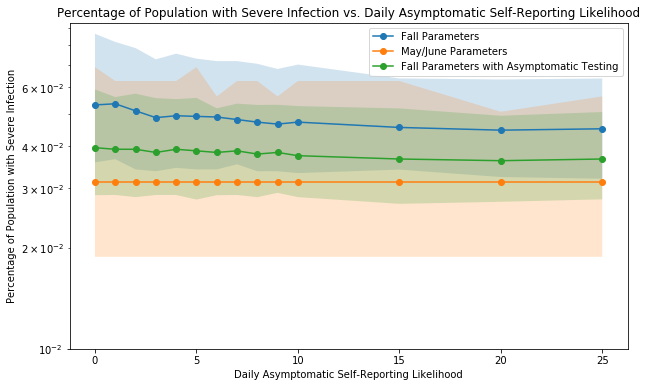

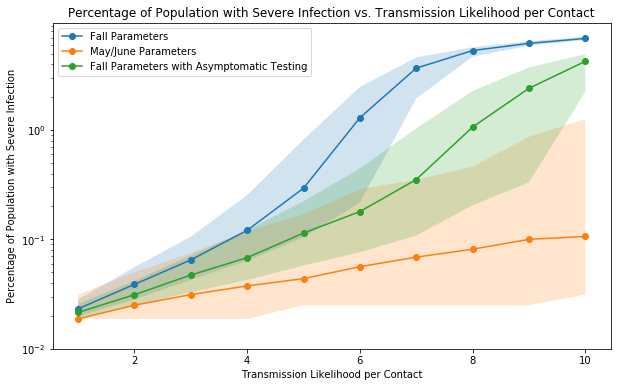

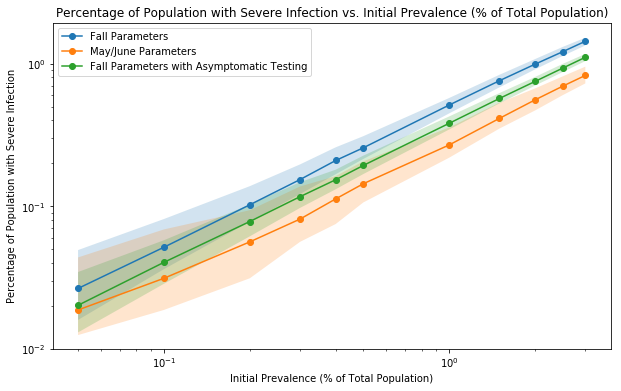

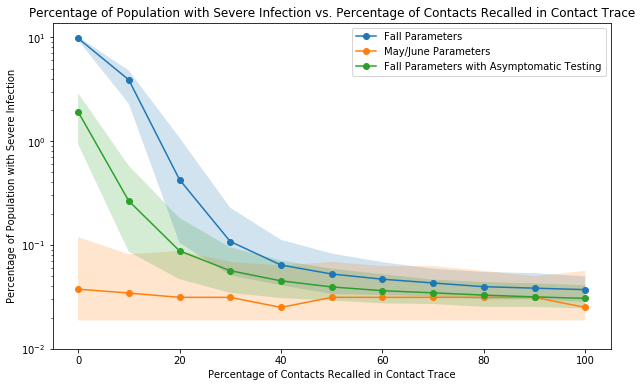

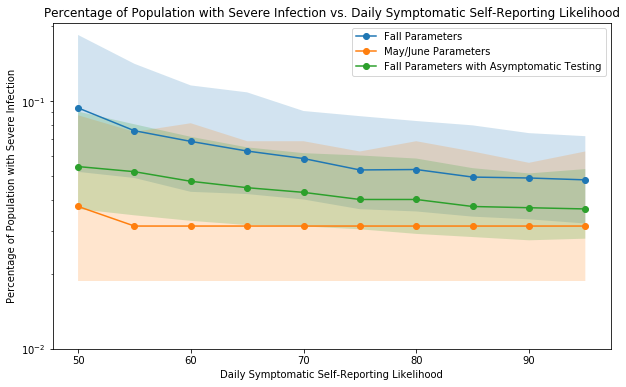

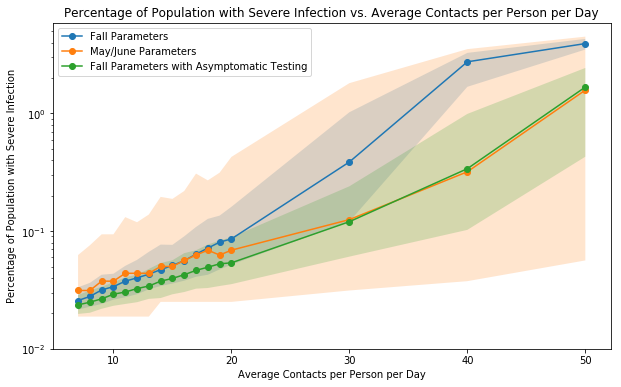

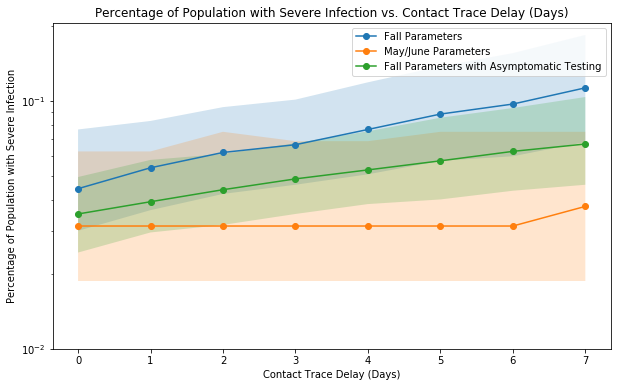

In [5]:
sim_names = set(fall_sim_results.keys())
for sim_name in sim_names:
    fall_dfs = fall_sim_results[sim_name]
    base_dfs = base_sim_results[sim_name]
    fall_testing_dfs = fall_testing_results[sim_name]
    plot_many_dfs_quantiles({'Fall Parameters': fall_dfs, 'May/June Parameters': base_dfs, 
                   'Fall Parameters with Asymptomatic Testing': fall_testing_dfs}, cum_severe_quantiles,
                            normalize_params[sim_name], x_log_scale=plot_log_scale[sim_name],
                 xlabel=plot_labels[sim_name], ylabel="Percentage of Population with Severe Infection",
                 title="Percentage of Population with Severe Infection vs. {}".format(plot_labels[sim_name]), 
                           q_low=0.1, q_high=0.9, alpha=0.2, y_min = 0, y_max=5, y_log_scale=True)

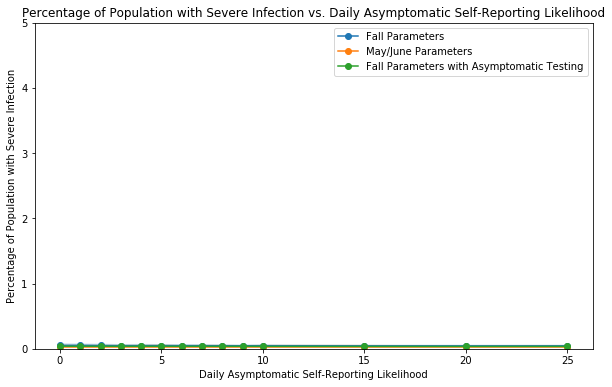

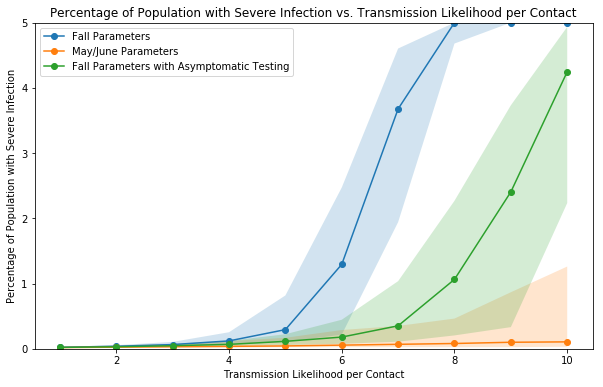

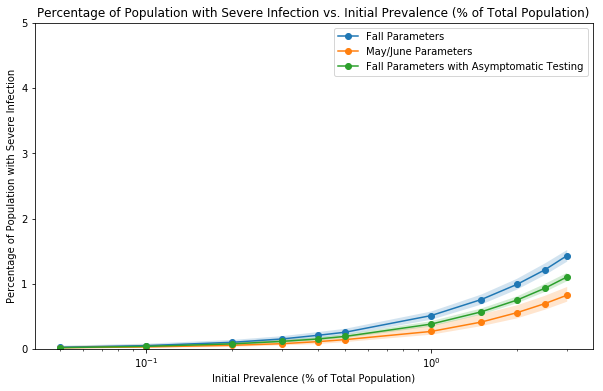

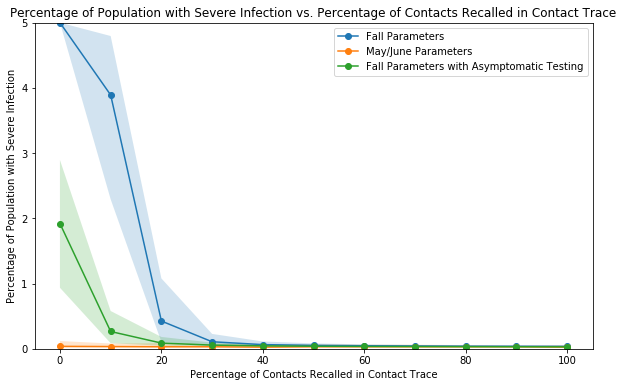

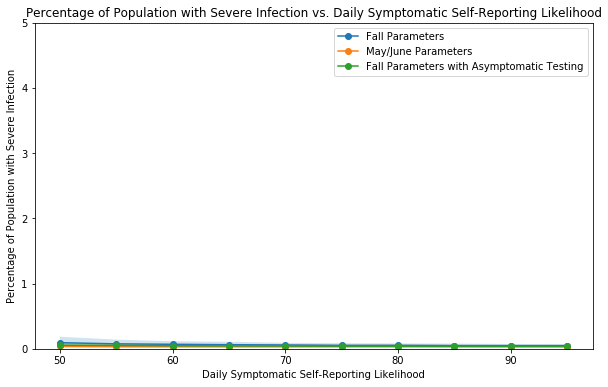

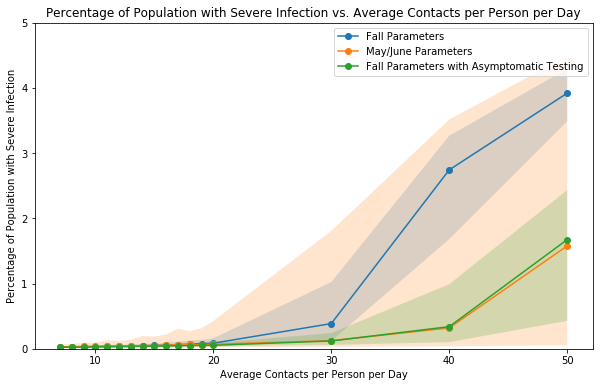

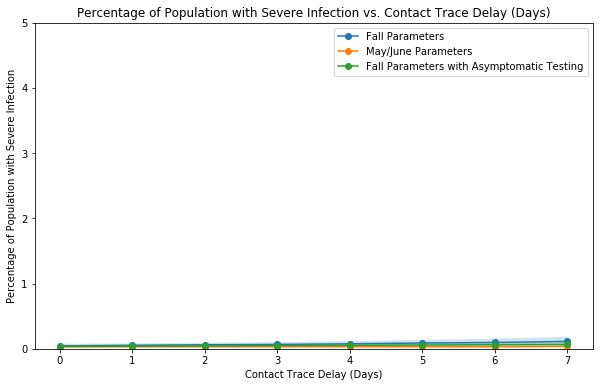

In [6]:
sim_names = set(fall_sim_results.keys())
for sim_name in sim_names:
    fall_dfs = fall_sim_results[sim_name]
    base_dfs = base_sim_results[sim_name]
    fall_testing_dfs = fall_testing_results[sim_name]
    plot_many_dfs_quantiles({'Fall Parameters': fall_dfs, 'May/June Parameters': base_dfs, 
                   'Fall Parameters with Asymptomatic Testing': fall_testing_dfs}, cum_severe_quantiles,
                            normalize_params[sim_name], x_log_scale=plot_log_scale[sim_name],
                 xlabel=plot_labels[sim_name], ylabel="Percentage of Population with Severe Infection",
                 title="Percentage of Population with Severe Infection vs. {}".format(plot_labels[sim_name]), 
                           q_low=0.1, q_high=0.9, alpha=0.2, y_min = 0, y_max=5, y_log_scale=False)

In [8]:
fall_testing_results['prevalence'].keys()

dict_keys(['initial_ID_prevalence.0.0005', 'initial_ID_prevalence.0.001', 'initial_ID_prevalence.0.002', 'initial_ID_prevalence.0.003', 'initial_ID_prevalence.0.004', 'initial_ID_prevalence.0.005', 'initial_ID_prevalence.0.01', 'initial_ID_prevalence.0.015', 'initial_ID_prevalence.0.02', 'initial_ID_prevalence.0.025', 'initial_ID_prevalence.0.03'])

In [13]:
id_cols

[]

In [18]:
all_cols

{'E_0',
 'E_1',
 'E_2',
 'E_3',
 'ID_0',
 'ID_1',
 'ID_2',
 'ID_3',
 'ID_4',
 'ID_5',
 'ID_6',
 'ID_7',
 'QI',
 'QS',
 'R',
 'S',
 'SyID_mild_0',
 'SyID_mild_1',
 'SyID_mild_10',
 'SyID_mild_11',
 'SyID_mild_12',
 'SyID_mild_13',
 'SyID_mild_2',
 'SyID_mild_3',
 'SyID_mild_4',
 'SyID_mild_5',
 'SyID_mild_6',
 'SyID_mild_7',
 'SyID_mild_8',
 'SyID_mild_9',
 'SyID_severe_0',
 'SyID_severe_1',
 'SyID_severe_10',
 'SyID_severe_11',
 'SyID_severe_12',
 'SyID_severe_13',
 'SyID_severe_2',
 'SyID_severe_3',
 'SyID_severe_4',
 'SyID_severe_5',
 'SyID_severe_6',
 'SyID_severe_7',
 'SyID_severe_8',
 'SyID_severe_9',
 'cumulative_mild',
 'cumulative_severe',
 'pre_ID_0',
 'pre_ID_1',
 'pre_ID_2',
 'pre_ID_3',
 'severity_0',
 'severity_1',
 'severity_2',
 'severity_3'}

In [17]:
all_cols = set(fall_testing_results['prevalence']['initial_ID_prevalence.0.0005'][0].columns)
id_cols = [col for col in all_cols if col[0:2] == 'ID']
fall_testing_results['prevalence']['initial_ID_prevalence.0.0005'][3][id_cols]

,ID_0,ID_1,ID_6,ID_3,ID_2,ID_4,ID_7,ID_5
0,3.0,4.0,1.0,2.0,3.0,2.0,0.0,1.0
1,4.0,3.0,0.0,1.0,2.0,1.0,0.0,1.0
2,3.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0
3,2.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,5.0,0.0,0.0,2.0
5,4.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0
6,3.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
8,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0
9,5.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [32]:

non_main_cols = set(['cumulative_mild',
 'cumulative_severe',
 'pre_ID_0',
 'pre_ID_1',
 'pre_ID_2',
 'pre_ID_3',
 'severity_0',
 'severity_1',
 'severity_2',
 'severity_3'])

In [39]:
sum(fall_testing_results['prevalence']['initial_ID_prevalence.0.001'][100][list(all_cols - non_main_cols - set('S'))].iloc[0])

35.0

# output from ID time sensitivity analysis

In [44]:
additional_dirs = """ID_mean_time_fall_testing.1590013806.65
ID_mean_time_fall.1590013796.7
ID_mean_time_base.1590013784.81""".split('\n')

for folder in additional_dirs:
    sims_in_dir = load_sim_dir("/nfs01/covid_sims/" + folder, verbose=False)
    print("Done loading {}".format(folder))
    if '_base' in folder:
        param_name = folder.split('_base')[0]
        base_sim_results[param_name] = sims_in_dir
    elif '_fall_testing' in folder:
        param_name = folder.split('_fall_testing')[0]
        fall_testing_results[param_name] = sims_in_dir
    elif '_fall' in folder:
        param_name = folder.split('_fall')[0]
        fall_sim_results[param_name] = sims_in_dir
    else:
        print("couldn't determinie fall or base")
        unallocated_results.append(sims_in_dir)

Done loading ID_mean_time_fall_testing.1590013806.65
Done loading ID_mean_time_fall.1590013796.7
Done loading ID_mean_time_base.1590013784.81


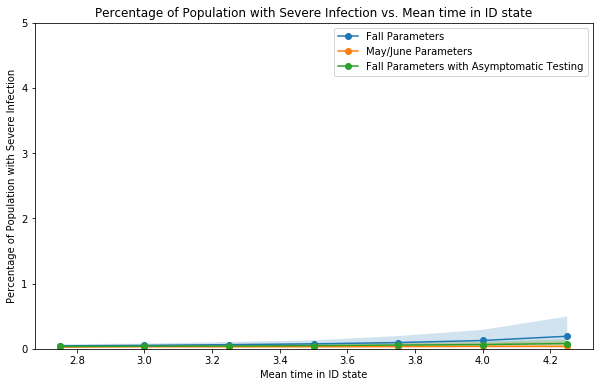

In [47]:
plot_many_dfs_quantiles({'Fall Parameters': fall_sim_results['ID_mean_time'], 
                         'May/June Parameters': base_sim_results['ID_mean_time'], 
                       'Fall Parameters with Asymptomatic Testing': fall_testing_results['ID_mean_time']}, 
                        cum_severe_quantiles,
                            False, x_log_scale=plot_log_scale[sim_name],
                 xlabel="Mean time in ID state", ylabel="Percentage of Population with Severe Infection",
                 title="Percentage of Population with Severe Infection vs. Mean time in ID state", 
                           q_low=0.1, q_high=0.9, alpha=0.2, y_min = 0, y_max=5, y_log_scale=False)

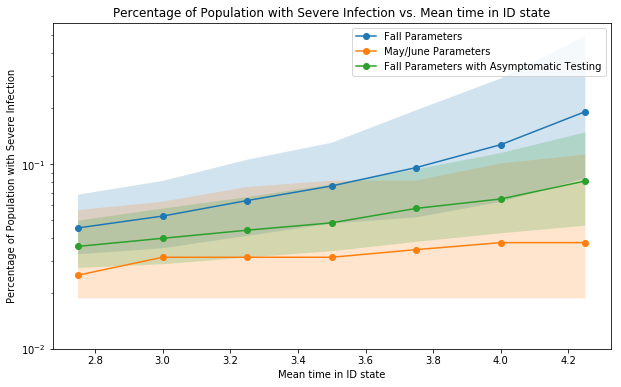

In [48]:
plot_many_dfs_quantiles({'Fall Parameters': fall_sim_results['ID_mean_time'], 
                         'May/June Parameters': base_sim_results['ID_mean_time'], 
                       'Fall Parameters with Asymptomatic Testing': fall_testing_results['ID_mean_time']}, 
                        cum_severe_quantiles,
                            False, x_log_scale=plot_log_scale[sim_name],
                 xlabel="Mean time in ID state", ylabel="Percentage of Population with Severe Infection",
                 title="Percentage of Population with Severe Infection vs. Mean time in ID state", 
                           q_low=0.1, q_high=0.9, alpha=0.2, y_min = 0, y_max=5, y_log_scale=True)

# output from ID time sensitivity analysis with stochastic prevalence levels

In [3]:
more_dirs = """ID_mean_time_fall_testing.1590015361.4
ID_mean_time_fall.1590015356.81
ID_mean_time_base.1590015344.04""".split('\n')

more_results = {}
for folder in more_dirs:
    sims_in_dir = load_sim_dir("/nfs01/covid_sims/" + folder, verbose=False)
    print("Done loading {}".format(folder))
    param_name = folder.split('.')[0]
    more_results[param_name] = sims_in_dir
    

Done loading ID_mean_time_fall_testing.1590015361.4
Done loading ID_mean_time_fall.1590015356.81
Done loading ID_mean_time_base.1590015344.04


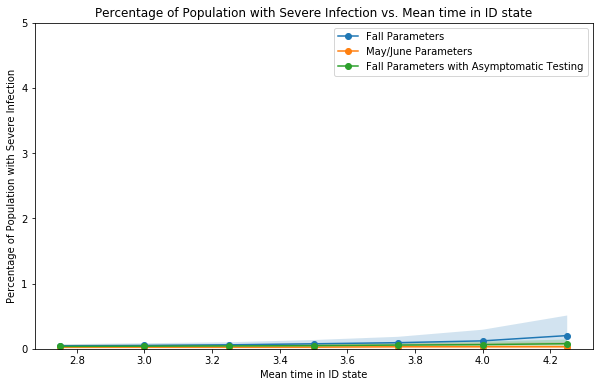

In [7]:
plot_many_dfs_quantiles({'Fall Parameters': more_results['ID_mean_time_fall'], 
                         'May/June Parameters': more_results['ID_mean_time_base'], 
                       'Fall Parameters with Asymptomatic Testing': more_results['ID_mean_time_fall_testing']}, 
                        cum_severe_quantiles,
                            False, x_log_scale=False,
                 xlabel="Mean time in ID state", ylabel="Percentage of Population with Severe Infection",
                 title="Percentage of Population with Severe Infection vs. Mean time in ID state", 
                           q_low=0.1, q_high=0.9, alpha=0.2, y_min = 0, y_max=5, y_log_scale=False)